In [353]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

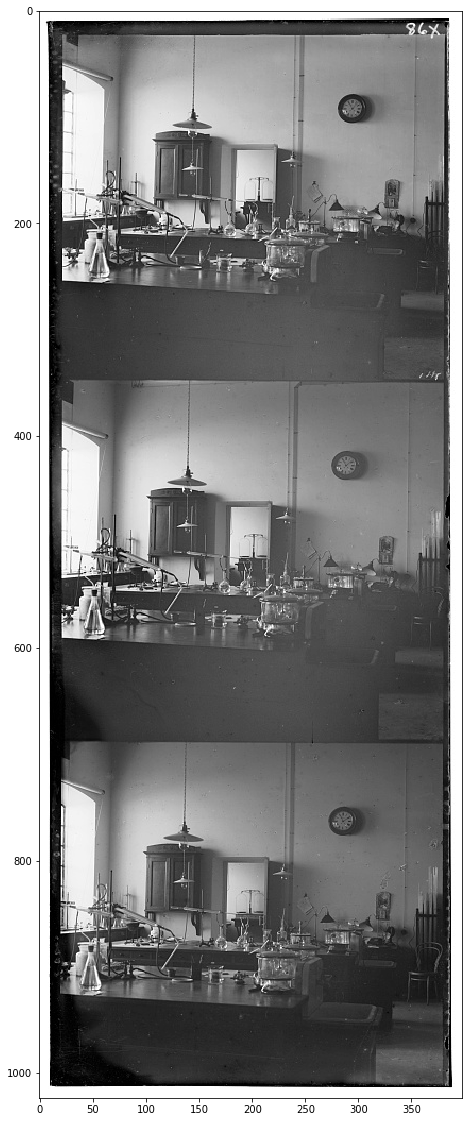

In [485]:
# Replace this string to the file that you want to align (must be in same directory as notebook)
file_str = "s2"
file_type = ".jpg"

# Read in an image
img = cv2.imread(file_str + file_type)

# Make figures bigger so its easier to see images
plt.rcParams["figure.figsize"] = (30,20)

# Convert to grayscale and display
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img,cmap='gray')

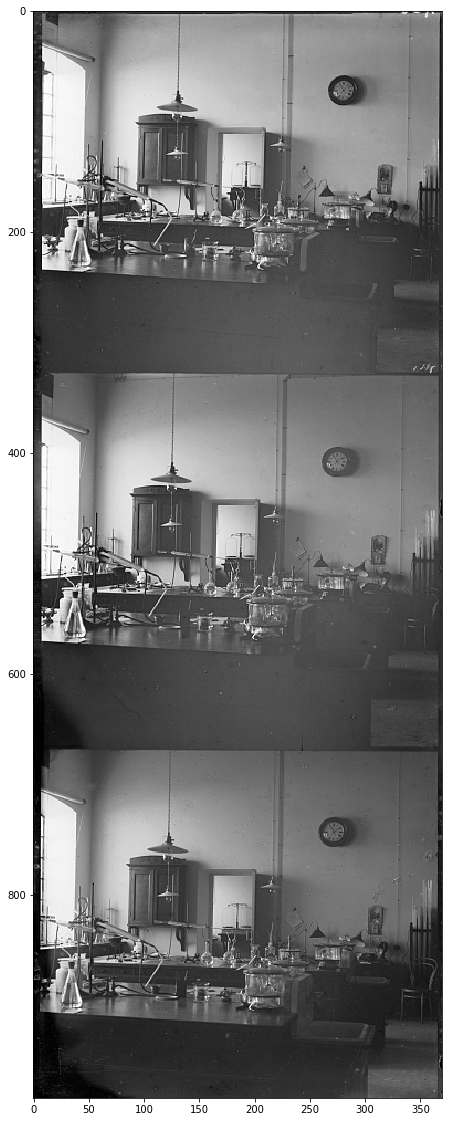

In [486]:
# Rudimentary cropping, performed by cropped a % of the width and height of the image
amount_w = 0.035
amount_h = 0.02
crop_width = round(img.shape[1] * amount_w)
crop_height = round(img.shape[0] * amount_h)
cropped_img = img[crop_height:-crop_height,crop_width:-crop_width]

# Trim off bottom rows until height is evenly divisible by 3
# so that it can be separated into B,G,R channels (just makes this cleaner)
while cropped_img.shape[0] % 3 != 0:
    cropped_img = cropped_img[:-1,:]
    
cv2.imwrite(file_str + "_cropped_task1" + file_type, cropped_img)
# Display cropped image
plt.imshow(cropped_img,cmap='gray')

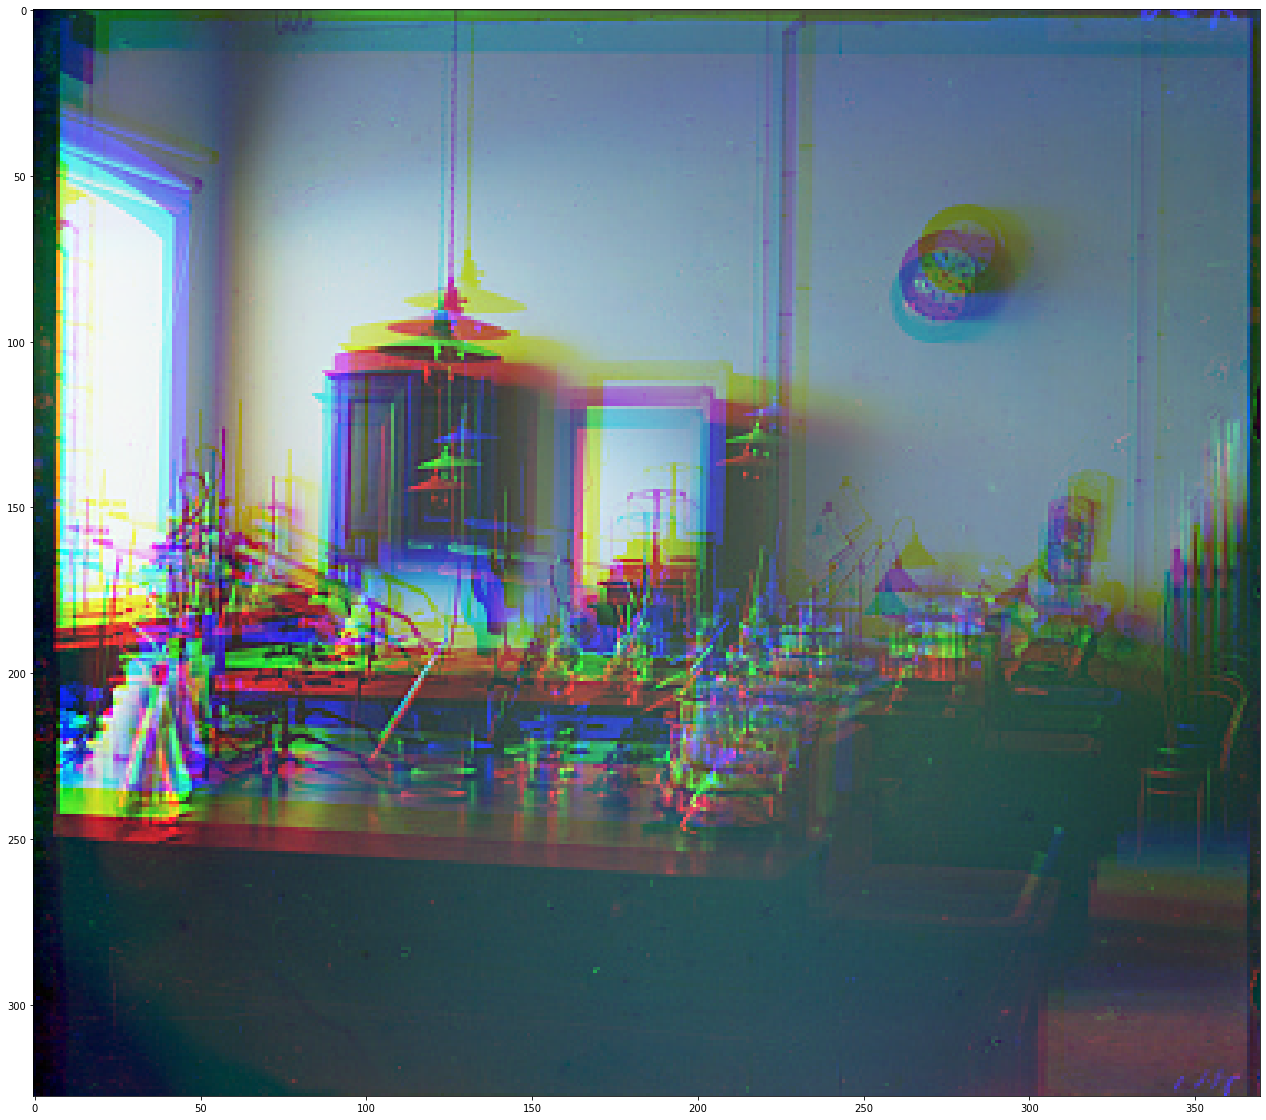

In [487]:
# Now that white border has been (roughly) cropped, simply divide image height-wise 
# into 3 sections to form the R, G and B channels
img_height = cropped_img.shape[0]

l = round(img_height/3)

b = cropped_img[0:l,:]
g = cropped_img[l:2*l,:]
r = cropped_img[2*l:,:]

# Stack into coloured image (BGR for OpenCV)
img_bgr = np.dstack((b,g,r))

# Convert to RGB so matplotlib can display
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)

Aligning green channel...
Aligning red channel...
Finished! Optimal offsets: 
Green: i = -8, j = 5
Red: i = -15, j = 8


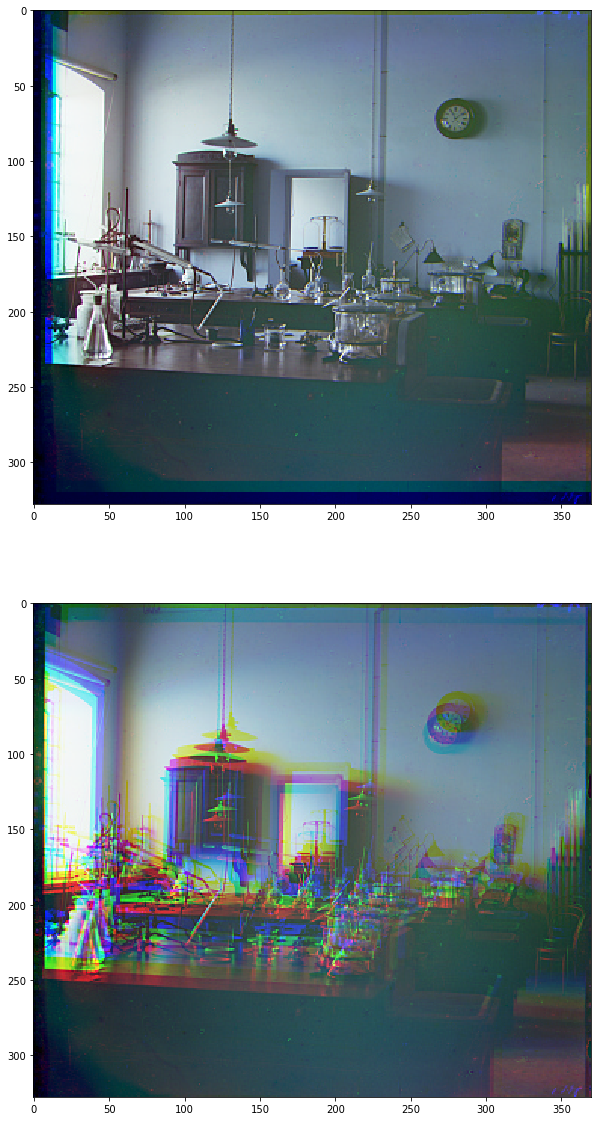

In [488]:
# Aligns img_b to img_a by holding img_a still and sliding img_b +/- num_offsets over img_a
# and calculating a score for how well it is aligned
# returns aligned image (same size as img_a and img_b), the offset for the aligned image
# and the calculated score
def align_channel(img_a, img_b, num_offsets):
    best_i = 0
    best_j = 0
    best_img_b = []
    
    # Start with a score of 0, since we are using normalized correlation coefficient
    # as the OpenCV metric
    best_score = 0
    for i in range(-num_offsets, num_offsets + 1):
        for j in range(-num_offsets, num_offsets + 1):
            
            # Roll img_b by current offsets that are being tested
            img_b_roll = np.roll(img_b, [i,j], axis=(0,1))

            # Bit mask img_b_roll, set all values outside of new image boundaries to 0
            mask = np.zeros(img_b.shape)
            
            # Wherever np.roll() "rolled over" intensity values, set these locations to 1 in the mask
            if i < 0:
                mask[(mask.shape[0]+i):,:] = 1
            elif i > 0:
                mask[:i,:] = 1
            if j < 0:
                mask[:,(mask.shape[1]+j):] = 1
            elif j > 0:
                mask[:,:j] = 1
                
            # now need to invert the mask and multiply with img_b_roll to clear the intensity values
            # that "rolled over", the result 0 columns and rows will be used to trim the image to only
            # the overlapping area
            mask = 1 - mask

            img_b_masked = img_b_roll * mask

            # Trim both channels so that all we have left
            # is overlapping area to perform the metric on
            new_img_a = img_a[~np.all(img_b_masked == 0, axis=1)]
            
            new_img_a = new_img_a[:, ~np.all(img_b_masked == 0, axis=0)]
            
            new_img_b = img_b_masked[~np.all(img_b_masked == 0, axis=1)]
            
            new_img_b = new_img_b[:, ~np.all(img_b_masked == 0, axis=0)]
            
            # Calculate score for current offset, if it's higher (ie better) than current score
            # then update best offset and image
            nccoeff = cv2.matchTemplate(new_img_b.astype(np.uint8), new_img_a.astype(np.uint8), cv2.TM_CCOEFF_NORMED)
            if nccoeff > best_score:
                best_score = nccoeff
                best_i = i
                best_j = j
                best_img_b = img_b_masked
    return (best_img_b, best_i, best_j, best_score)

    
b = img_bgr[:,:,0]
g = img_bgr[:,:,1]
r = img_bgr[:,:,2]

print("Aligning green channel...")
g, i_g, j_g, score_g = align_channel(b,g,30)
print("Aligning red channel...")
r, i_r, j_r, score_r = align_channel(b,r,30)
print("Finished! Optimal offsets: ")

print("Green: i = " + str(i_g) + ", j = " + str(j_g))
print("Red: i = " + str(i_r) + ", j = " + str(j_r))

g = g.astype(np.uint8)
r = r.astype(np.uint8)

final_img = np.dstack((b,g,r))

# Write aligned image to file
cv2.imwrite(file_str + "_task1.png", final_img)

# Write original misaligned image to file
cv2.imwrite(file_str + "_orig_task1.png", img_bgr)

final_img = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)

# Plot aligned image
plt.subplot(2,1,1)
plt.imshow(final_img)
# Plot original misaligned image
plt.subplot(2,1,2)
plt.imshow(img_rgb)